# Tutorial 5: Recurrent Neural Networks with Pytorch (Long Short-Term Memory (LSTM) Networks)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Create Dataset
The data we use is a collection of two years' hourly data from California Department of Transportation, which describes the road occupancy rates measured by different sensors on San Francisco Bay area freeways. 

For convenience we have intercepted the data from sensor 0 and sensor 1 for use in the tutorial and exercise. This is provided in the `traffic.csv`. You can also download the whole dataset from [Here](https://drive.google.com/drive/folders/1M3gTc1DSvnUFMI57p70VFH5MHhZh3wC8) and try other sensors' data. 

Since the data are arranged in chronological order, you can take any sensor's data (a column in the whole dataset) to make a single-feature time series. Below you will use pandas library to read the CSV file and convert a series into a 2D numpy array, then plot it using matplotlib:

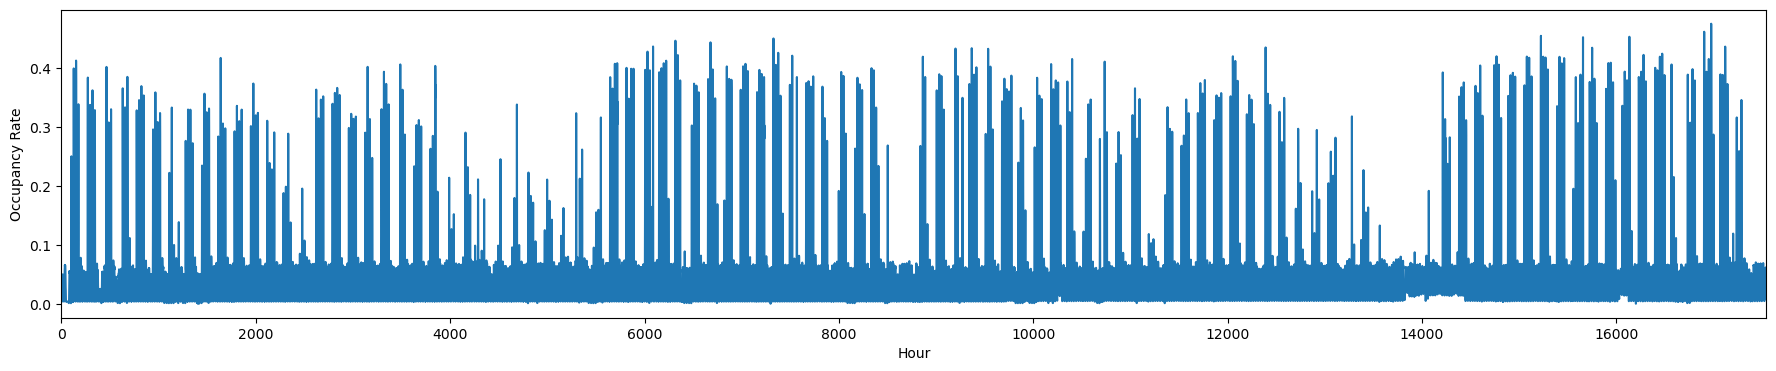

In [2]:
df = pd.read_csv("./traffic.csv")
timeseries = df["0"].values.reshape(-1, 1).astype(np.float32)

plt.figure(figsize=(22, 4))
plt.plot(timeseries)
plt.xlabel("Hour")
plt.ylabel("Occupancy Rate")
plt.xlim(0, len(timeseries))
plt.show()

This time series has 17544 (2\*365\*24+24) time steps. To demonstrate the predictive power of our model, the time series is splitted into training and test sets. 

**Unlike other dataset, usually time series data are splitted without shuffling. That is, the training set is the first half of time series and the remaining will be used as the test set.** 

This can be easily done on a numpy array:

In [4]:
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print(train.shape, test.shape)

(14035, 1) (3509, 1)


The more complicated problem is how do you want the network to predict the time series. Usually time series prediction is done on a window. That is, given data from time t - w to time t, you are asked to predict for time t+1  (or deeper into the future). The size of window governs how much data you are allowed to look at when you make the prediction. This is also called the look back period.

In [5]:
# a function to generate a dataset of fixed window from a time series. 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback-2):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [6]:
# generate features and labels for the training and testing datasets
lookback = 240
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
y_train, y_test = y_train[:, -1, :], y_test[:, -1, :]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([13793, 240, 1]) torch.Size([13793, 1])
torch.Size([3267, 240, 1]) torch.Size([3267, 1])


In [7]:
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=64)

## Define Model

- The LSTM layer is created with option `batch_first=True` because the tensors you prepared is in the dimension of (window sample, time steps, features) and where a batch is created by sampling on the first dimension.
- By changing the parameter `num_layers` we can easily stack multiple LSTM layers.
- By setting the `dropout` parameter to a non-zero value, we can introduce a Dropout layer on the outputs of each LSTM layer except the last layer to avoid overfitting.
- `nn.BatchNorm` can be used to perform batch normlization which can help avoid overfiiting.
- Activation function can be changed by using different function when define `self.activation`.


In [8]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, dropout=0, batch_first=True)
        self.linear = nn.Linear(50, 1)
        self.bn = nn.BatchNorm1d(50)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :] # we extract only the last time step from the model output as prediction we are going to predict t+1
        x = self.bn(x)
        x = self.linear(x)
        x = self.activation(x)
        return x

## Training and Testing
First we instantiate the model and set up the optimizer and loss function.

In [9]:
model = AirModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

### Model parameters initialization
[`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html#torch-nn-init) provides a variety of initialization methods. We can manually initialize the model parameters by traversing each layer of the model.

In [10]:
for m in model.modules():
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "weight" in name:
                nn.init.xavier_normal_(param)
            elif "bias" in name:
                nn.init.zeros_(param)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

### Training and testing

In [11]:
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device))
        train_rmse = np.sqrt(loss_fn(y_pred, y_train.to(device)).item())
        y_pred = model(X_test.to(device))
        test_rmse = np.sqrt(loss_fn(y_pred, y_test.to(device)).item())
    
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0828, test RMSE 0.0878
Epoch 1: train RMSE 0.0554, test RMSE 0.0563
Epoch 2: train RMSE 0.0476, test RMSE 0.0483
Epoch 3: train RMSE 0.0408, test RMSE 0.0463
Epoch 4: train RMSE 0.0513, test RMSE 0.0675
Epoch 5: train RMSE 0.0429, test RMSE 0.0443
Epoch 6: train RMSE 0.0395, test RMSE 0.0432
Epoch 7: train RMSE 0.0553, test RMSE 0.0506
Epoch 8: train RMSE 0.0370, test RMSE 0.0458
Epoch 9: train RMSE 0.0390, test RMSE 0.0438


The training set is plotted in red while the test set is plotted in green. The blue curve is what the actual data looks like. You can see that the model can fit well both to the training set and the test set.

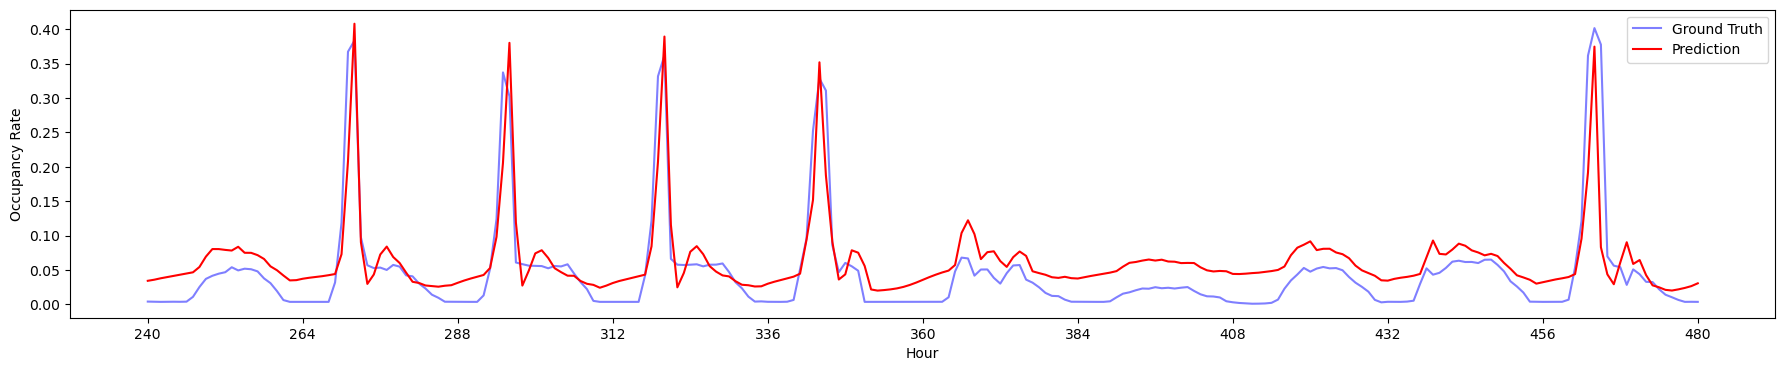

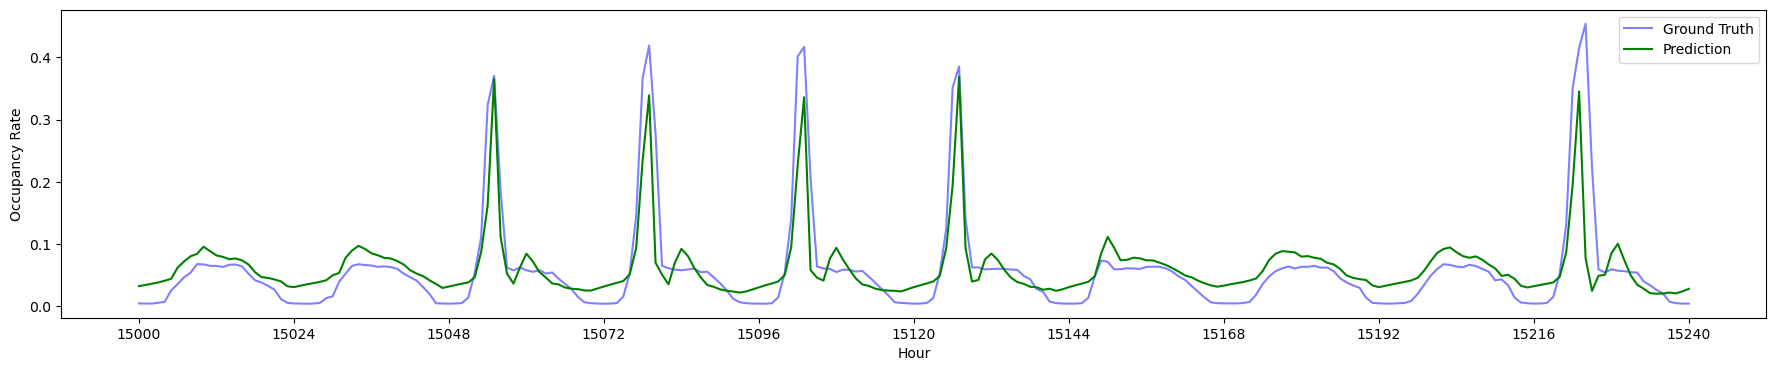

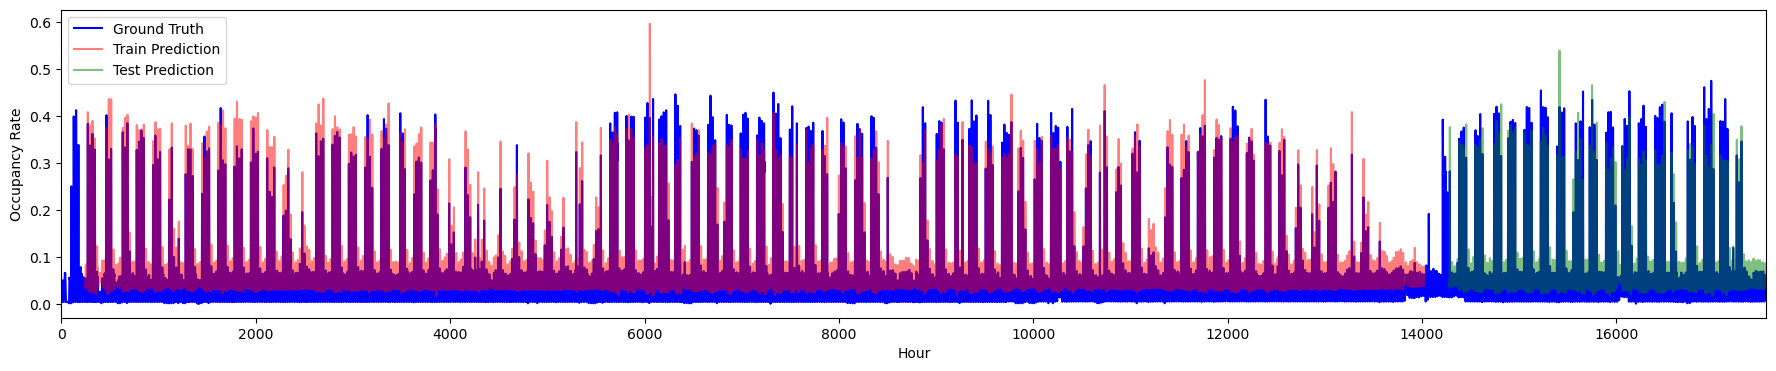

In [12]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device))
    # y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size - 2] = model(X_train.to(device)).cpu().numpy()
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback: len(timeseries)-2] = model(X_test.to(device)).cpu().numpy()

train_plot_range = np.arange(240, 481)
plt.figure(figsize=(22, 4))
plt.plot(train_plot_range, timeseries[train_plot_range], c='b', label="Ground Truth", alpha=0.5,)
plt.plot(train_plot_range, train_plot[train_plot_range], c='r', label="Prediction")
plt.xlabel("Hour")
plt.ylabel("Occupancy Rate")
plt.xticks(np.arange(240, 481, 24))
plt.legend()  
plt.show()

test_plot_range = np.arange(15000, 15241)
plt.figure(figsize=(22, 4))
plt.plot(test_plot_range, timeseries[test_plot_range], c='b', label="Ground Truth", alpha=0.5)
plt.plot(test_plot_range, test_plot[test_plot_range], c='g', label="Prediction")
plt.xlabel("Hour")
plt.ylabel("Occupancy Rate")
plt.xticks(np.arange(15000, 15241, 24))
plt.legend()  
plt.show()

# plot
plt.figure(figsize=(22, 4))
plt.plot(timeseries, c='b', label="Ground Truth")
plt.plot(train_plot, c='r', alpha=0.5, label="Train Prediction")
plt.plot(test_plot, c='g', alpha=0.5, label="Test Prediction")
plt.xlabel("Hour")
plt.ylabel("Occupancy Rate")
plt.xlim(0, len(timeseries))
plt.legend()
plt.show()